# Cancer Genomics Analysis

Samuel Moijueh

2020-12-02

<img src="https://user-images.githubusercontent.com/42754056/58846596-5b0db080-8645-11e9-8d8c-16c9d56b7fb6.jpg" style="width: 500px" title="cancer cells">

<br>

Objective: Explore the cancer genomic data (tumor/normal whole exome sequencing) from 50 patients that received the same type of treatment, half of whom responded.

The data for this analysis from the Van Allen lab at the Dana-Farber Cancer Institute: <a href="https://drive.google.com/file/d/1pX78BUsh__VIVg4tJNChCA5b8h4tkjj-/view">Google Drive</a>.


<br>

**Overall question: Can we identify mutations that are associated with the treatment response?**


In [1]:
#!/usr/bin/env python

""" Basic Utils """
import warnings
import glob
import os
from collections import Counter

""" Data Analysis and Visualization """
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import math

INPUT_PATH = "mafs/"

# Step 1: Download the Dataset

* import and store each MAF (Mutation Annotation Format) file into a pandas dataframe
* create a dictionary to hold the dataframes; the dictionary will be indexed by the patient ID

In [2]:
patient_maf_df_collection = {}

for filename in glob.glob(INPUT_PATH + '*.maf'):
    base = os.path.basename(filename)
    patient_id = base.split(".")[0]
    patient_maf_df_collection[patient_id] = pd.read_csv(filename, sep="\t")

# Step 2: Subset For Nonsynonymous Mutations
* subset for mutations that are not of the Variant Classification “Silent”
    * get rid of silent mutations

In [3]:
subset_patient_maf_df_collection = {}

for key in patient_maf_df_collection.keys():
    df = patient_maf_df_collection[key]
    subset_df = df.loc[df['Variant_Classification'] != "Silent"]
    subset_patient_maf_df_collection[key] = subset_df.applymap(str)

<!--To verify that the the solution is correct, we can check the MAF dataframe before and after for one of the patients.!--> 

We can check the dataframe before and after to verify that the solution is correct.

Notice that the rows corresponding to Silent mutations are absent after subsetting.

In [4]:
print("=== Original Dataset ===")
print(patient_maf_df_collection['Patient-0']['Variant_Classification'].value_counts())
print("")
print("=== Subset Dataset ===")
print(subset_patient_maf_df_collection['Patient-0']['Variant_Classification'].value_counts())

=== Original Dataset ===
Missense_Mutation    208
Silent                94
Nonsense_Mutation     20
Splice_Site           12
Name: Variant_Classification, dtype: int64

=== Subset Dataset ===
Missense_Mutation    208
Nonsense_Mutation     20
Splice_Site           12
Name: Variant_Classification, dtype: int64


# Step 3: Find the 15 Most Common 

<br>

Genes names are included in the column Hugo_Symbol and protein changes are stored in the column Protein_Change.

In [5]:
def most_common(column_name):
    value_counter = []
    for k,v in subset_patient_maf_df_collection.items():
        a = v[column_name].values
        unique, counts = np.unique(a, return_counts=True)
        value_counter.append(Counter(dict(zip(unique, counts))))

    counter = sum(value_counter, Counter())
    return(counter)

### Most Common Gene Mutations

In [6]:
gene_mutations = most_common('Hugo_Symbol')
most_common_gene_mutations = gene_mutations.most_common()[:15]
pd.DataFrame(np.array(most_common_gene_mutations).reshape(15,2), columns=('Gene Mutation', 'Frequency'))

,Gene Mutation,Frequency
0,TTN,41
1,TP53,30
2,ERBB4,27
3,MUC16,22
4,SPEN,22
5,KMT2C,20
6,KMT2D,17
7,ERBB3,16
8,FRG1B,14
9,ZNF91,13


### Most Common Protein Changes

In [7]:
protein_changes = most_common('Protein_Change')
most_common_protein_changes = protein_changes.most_common()[0:16]
pd.DataFrame(np.array(most_common_protein_changes).reshape(16,2), columns=('Protein Change', 'Frequency'))

,Protein Change,Frequency
0,nan,209
1,p.S1289A,14
2,p.S57L,6
3,p.E70K,6
4,p.E338K,6
5,p.E545K,6
6,p.E301K,6
7,p.E352K,5
8,p.S330F,5
9,p.I97M,5


# Step 4: Perform Statistical Test (Gene Enrichment Analysis)

<br>

* Perform a statistical test to explore if any mutated genes are enriched in patients who either responded or not.

I will perform the Fisher's Exact Test by constructing following contingency table:

<br>

<table>
  <thead>
    <tr>
      <th></th>
      <th>Responder</th>
      <th>Non-Responder</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Gene A mutant</td>
      <td>#</td>
      <td>#</td>
    </tr>
    <tr>
      <td>Gene A wild-type</td>
      <td>#</td>
      <td>#</td>
    </tr>
  </tbody>
</table>

<br>

There are 50 patients in the study therefore the cells of the contingency table should add up to 50.

**Overall Question: Are there any mutations that are associated with treatment response?**

$H_{o}$: For a given gene, an observed imbalance in response vs non-response is not statistically significant.

$H_{A}$: For a given gene, an observed imbalance in response vs non-response is significantly significant.

In [8]:
mutated_gene_list = gene_mutations.keys()
patient_sample_list = subset_patient_maf_df_collection.keys()

sample_information = pd.read_csv('sample-information.tsv', sep="\t")

In [9]:
def get_contingency_table(patient_id,gene):
    gene_count = np.sum(subset_patient_maf_df_collection[patient_id]['Hugo_Symbol'] == gene)
    response = sample_information[sample_information['Patient_ID'] == patient_id]['Response'].values[0]

    if gene_count == 0 and response == 'Non-Responder':
        return(np.array([[0,0],[0,1]]))
    if gene_count > 0 and response == 'Non-Responder':
        return(np.array([[0,1],[0,0]]))
    if gene_count == 0 and response == 'Responder':
        return(np.array([[0,0],[1,0]]))
    if gene_count > 0 and response == 'Responder':
        return(np.array([[1,0],[0,0]]))

In [10]:
fisher_exact_pval = {}             # the fisher's exact test p-values
fisher_exact_oddsratio = {}        # the fisher's exact test odds radios
mutated_patients_per_gene = {}     # the number of mutated patients per gene

for gene in mutated_gene_list:
    contingency_table = np.array([[0,0],[0,0]])
    for patient_id in patient_sample_list:
        contingency_table += get_contingency_table(patient_id,gene)
    
    # sanity check -- if the cell values of the contingency table sum greater than 50 then display an error message
    if contingency_table.sum() != 50:
        print("ERROR!! gene name = " + gene)
        break
        
    number_of_mutated_patients = sum(contingency_table[0])
    oddsratio, pvalue = stats.fisher_exact(contingency_table)
    fisher_exact_pval[gene] = pvalue
    fisher_exact_oddsratio[gene] = oddsratio
    mutated_patients_per_gene[gene] = number_of_mutated_patients

### Bonferroni Multiple Test Correction

We're performing a Fisher's Exact Test for every individual per gene. There are 50 individual patients in the study. Therefore, there are 50 hypothesis tests per gene. We need to perform a multiple test correction.

One option is the Bonferroni Multiple Test Correction. It is calculated by dividing the specified Type I error (alpha = 0.05) by the number of hypothesis tests. 

Bonferroni correction $=α/N$

Genes having a p-value lower than the Bonferroni correction (the new alpha) will be determined as significant.

Note: The Bonferroni correction tends to be a bit too conservative. An alternative multiple test correction is the False Discovery Rate.

In [11]:
bonferroni_correction = 0.05 / 50
bonferroni_correction

0.001

# Step 5: Scatterplot of the Results (Gene Enrichment Analysis)

Create a scatter plot of genes with the number of mutated patients on the x-axis and your results from question 4 on the y-axis.

Can the axes be scaled or transformed in any way to improve readability?

In [12]:
""" create a dataframe of the Fisher's Exact Test Results and Number of Mutated Patients"""
x_num = [0] * len(mutated_gene_list)
y_pval = [0] * len(mutated_gene_list)
gene_name = [0] * len(mutated_gene_list)

for i, gene in enumerate(fisher_exact_pval.keys(), 0):
    x_num[i] = mutated_patients_per_gene[gene]
    y_pval[i] = fisher_exact_pval[gene]
    gene_name[i] = gene

gene_enrichment_results = df = pd.DataFrame(list(zip(x_num, y_pval, gene_name)), columns =['Mutated_Patients', 'p-value', 'Gene_Name'])

In [13]:
print("There are {0} nonsynonymous mutations in the study.".format(str(gene_enrichment_results.shape[0])))

There are 6927 nonsynonymous mutations in the study.


In [14]:
gene_enrichment_results.head()

,Mutated_Patients,p-value,Gene_Name
0,1,1.000000,ADC
1,1,1.000000,ADNP
2,2,1.000000,AFF2
3,2,1.000000,AGAP10
4,5,0.348676,AGO3


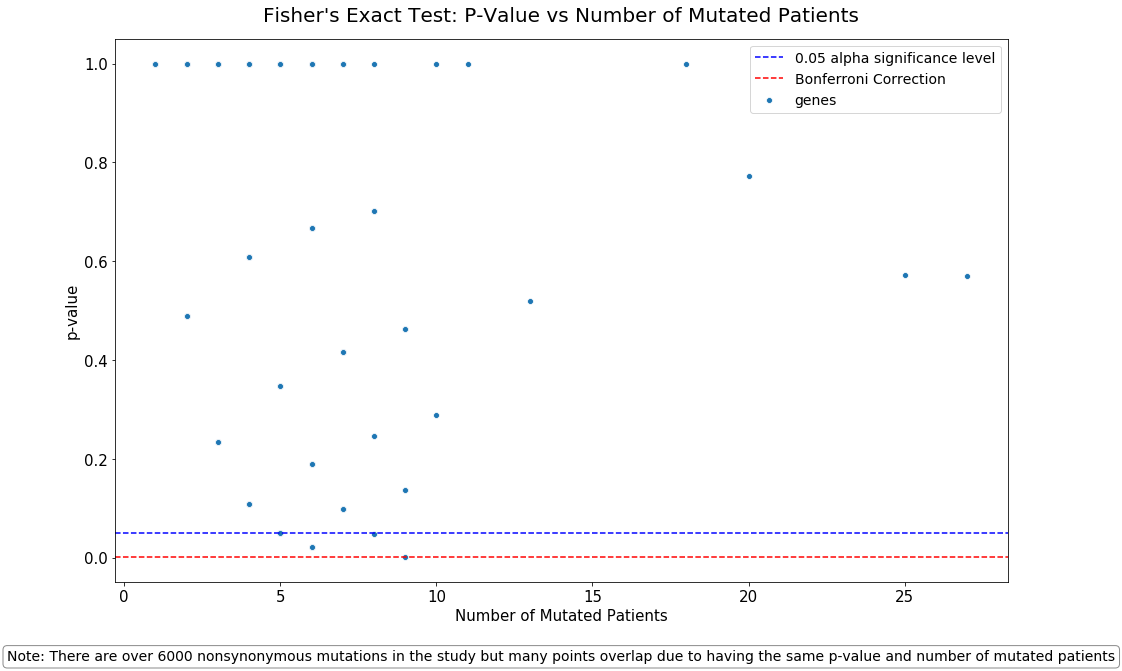

In [15]:
""" Create the Scatter Plot """ 
fig, ax = plt.subplots(figsize=(16,10))
ax.tick_params(axis='both', which='major', labelsize=15)
ax = sns.scatterplot(x="Mutated_Patients", y="p-value", data=gene_enrichment_results)
ax.set_title('Fisher\'s Exact Test: P-Value vs Number of Mutated Patients',y=1.02, fontsize=20)
ax.set_xlabel('Number of Mutated Patients', fontsize=15, y=1.08)
ax.set_ylabel('p-value', fontsize=15)
ax.axhline(0.05, color = 'blue', ls='--')
ax.axhline(bonferroni_correction, color = 'red', ls='--')
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

ax.text(14, -0.2, "Note: There are over 6000 nonsynonymous mutations in the study but many points overlap due to \
having the same p-value and number of mutated patients", ha="center", va="center", size=14, bbox=bbox_props)
plt.legend(("0.05 alpha significance level", "Bonferroni Correction", "genes"), prop={'size': 14})

Note: We can improve the visualization by increasing the radius of the data points to reflect the number of mutations that cluster. Here is an <a href="https://iiif.elifesciences.org/lax:21778%2Felife-21778-fig4-figsupp2-v3.tif/full/1500,/0/default.jpg" target="_blank">Example</a>.

<br>

## Applying Log Transformation to p-values

<br>

We're interested in genes which have p-values < 0.05. These genes are currently positioned towards the bottom of the plot.

We can improve readibility by transforming the y-axis onto a logarithmic scale: -log10(p-value). 

This will help us better visualize significant genes by effectively moving them to top of the plot.

In [16]:
""" Apply Log Transformation to the p-values """
gene_enrichment_results['negative_log10_pval'] = -np.log10(gene_enrichment_results['p-value']) + 0

""" Display results """
gene_enrichment_results.sort_values(by=['negative_log10_pval'],  ascending=False)[0:9]

,Mutated_Patients,p-value,Gene_Name,negative_log10_pval
414,9,0.001631,ERCC2,2.787590
1783,6,0.022290,HERC1,1.651894
1909,6,0.022290,AKAP9,1.651894
197,6,0.022290,HECTD1,1.651894
67,6,0.022290,MROH2B,1.651894
227,6,0.022290,MACF1,1.651894
218,8,0.048797,KMT2C,1.311606
55,5,0.050152,KIAA1109,1.299712
26,5,0.050152,COL6A6,1.299712


### Most Significantly Enriched Gene

The most significantly enriched gene is ERCC2.

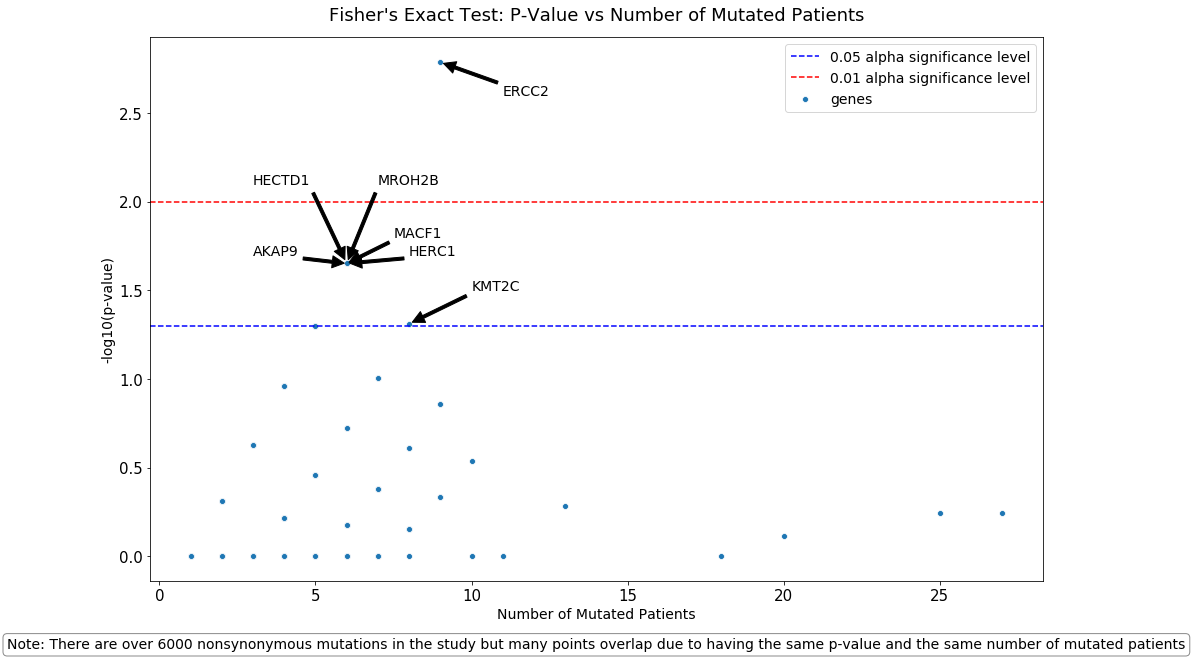

In [17]:
""" Create the Scatter Plot """ 
fig, ax2 = plt.subplots(figsize=(16,10))
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2 = sns.scatterplot(x="Mutated_Patients", y="negative_log10_pval", data=gene_enrichment_results)
ax2.set_title('Fisher\'s Exact Test: P-Value vs Number of Mutated Patients',y=1.02, fontsize=18)
ax2.set_xlabel('Number of Mutated Patients', fontsize=14, y=1.08)
ax2.set_ylabel('-log10(p-value)', fontsize=14)
ax2.axhline(-math.log10(0.05), color = 'blue', ls='--')
ax2.axhline(-math.log10(0.01), color = 'red', ls='--')

ax2.text(14, -0.5, "Note: There are over 6000 nonsynonymous mutations in the study but many points overlap due to \
having the same p-value and the same number of mutated patients", ha="center", va="center", size=14, bbox=bbox_props)
plt.legend(("0.05 alpha significance level", "0.01 alpha significance level", "genes"), prop={'size': 14})

""" gene annotation """
ax2.annotate('ERCC2', xy = (9, -math.log10(0.001631)), xytext = (11, 2.6), arrowprops = dict(facecolor = 'black', shrink = 0.05, width=3), fontsize = 14 )
ax2.annotate('HERC1', xy = (6, -math.log10(0.022290)), xytext = (8, 1.7), arrowprops = dict(facecolor = 'black', shrink = 0.05, width=3), fontsize = 14 )
ax2.annotate('AKAP9', xy = (6, -math.log10(0.022290)), xytext = (3, 1.7), arrowprops = dict(facecolor = 'black', shrink = 0.05, width=3), fontsize = 14 )
ax2.annotate('HECTD1', xy = (6, -math.log10(0.022290)), xytext = (3, 2.1), arrowprops = dict(facecolor = 'black', shrink = 0.05, width=3), fontsize = 14 )
ax2.annotate('MROH2B', xy = (6, -math.log10(0.022290)), xytext = (7, 2.1), arrowprops = dict(facecolor = 'black', shrink = 0.05, width=3), fontsize = 14 )
ax2.annotate('MACF1', xy = (6, -math.log10(0.022290)), xytext = (7.5, 1.8), arrowprops = dict(facecolor = 'black', shrink = 0.05, width=3), fontsize = 14 )
ax2.annotate('KMT2C', xy = (8, -math.log10(0.048797)), xytext = (10, 1.5), arrowprops = dict(facecolor = 'black', shrink = 0.05, width=3), fontsize = 14 )
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

# Step 6: Nonsynonymous Mutations Per Megabase

<br>

How many samples are wild-type versus mutant with respect to the most significantly enriched gene from Question 4?

In [18]:
gene = 'ERCC2'
gene_phenotype = []
contingency_table = np.array([[0,0],[0,0]])
for patient_id in patient_sample_list:
    contingency_table += get_contingency_table(patient_id,gene)
    status = 'wild-type' if np.sum(subset_patient_maf_df_collection[patient_id]['Hugo_Symbol'] == gene) == 0 else 'mutant'
    gene_phenotype.append(status)

contingency_table

array([[ 9,  0],
       [16, 25]])

In [19]:
gene_phenotype.count('mutant')

9

<table>
  <thead>
    <tr>
      <th></th>
      <th>Responder</th>
      <th>Non-Responder</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Gene A mutant</td>
      <td>9</td>
      <td>0</td>
    </tr>
    <tr>
      <td>Gene A wild-type</td>
      <td>16</td>
      <td>25</td>
    </tr>
  </tbody>
</table>

#### 41 samples are wild-type and 9 samples are mutant with respect to the most significantly enriched gene ERCC2

## Examine Nonsynonymous Mutatations Per Megabase in Mutant vs Wild-Type Samples
<br>

Plot the number of nonsynonymous mutations per megabase in the mutant vs. wild-type samples. 

Y-axis is nonsynonymous mutations per megabase. X-axis is categorical: mutant vs. wild-type samples (two different columns)

In [20]:
df = sample_information[['Patient_ID', 'Response', 'Nonsynonymous_mutations_per_Mb']]
df.insert(loc=3, column='gene_phenotype', value=gene_phenotype)
df.head()

,Patient_ID,Response,Nonsynonymous_mutations_per_Mb,gene_phenotype
0,Patient-0,Non-Responder,6.77,wild-type
1,Patient-1,Responder,6.14,wild-type
2,Patient-2,Responder,2.84,mutant
3,Patient-3,Non-Responder,5.00,wild-type
4,Patient-4,Responder,10.50,wild-type


Text(0,0.5,'Nonsynonymous Mutations Per Mb')

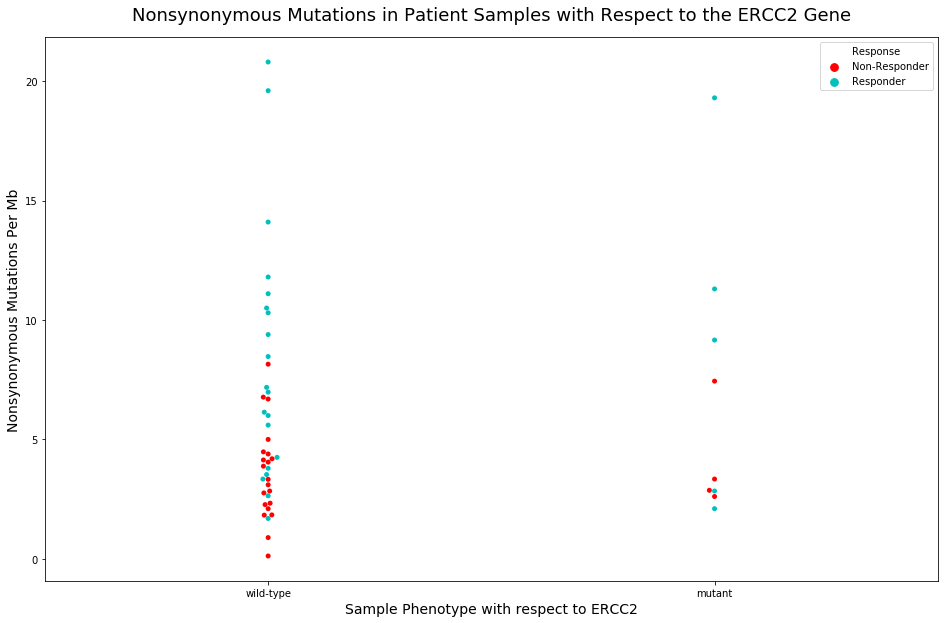

In [21]:
fig, ax3 = plt.subplots(figsize=(16,10))

""" create categorical scatter plot """ 
ax3 = sns.swarmplot(x="gene_phenotype", y="Nonsynonymous_mutations_per_Mb", hue="Response",
              palette=["r", "c"], data=df)

ax3.set_title('Nonsynonymous Mutations in Patient Samples with Respect to the ERCC2 Gene',y=1.02, fontsize=18)
ax3.set_xlabel('Sample Phenotype with respect to ERCC2', fontsize=14, y=1.08)
ax3.set_ylabel('Nonsynonymous Mutations Per Mb', fontsize=14)

### Is there a significant difference in the number of mutations between the two groups?

<br>

There are more wild-type samples than mutant samples (41 to 9) with respect to the ERCC2 gene therefore it is hard to say if there is a significant different in the number of mutations between the two groups. 

We would have to perform a statistical test to determine if there is a significant difference in the number of nonsynonymous mutations between wild-type and mutant samples. A statistical test that comes to mind is the t-test -- of course I would have to check the test assumptions. There could be other statistical tests we could use as well.

Just from eye-balling the categorical scatter plot, if we could extrapolate or add more mutant samples for this particular gene, it doesn't appear there would be a significant difference in the number of nonsynonymous mutations between wild-type and mutant samples.

# Step 7: Conclusion

<br>

## Write conclusions you have made based on your analysis.

<br>

------

<br>

The most significantly enriched gene from the 50 patient cohort in this study was ERCC2. 

The contigency table for this gene is:

<table>
  <thead>
    <tr>
      <th></th>
      <th>Responder</th>
      <th>Non-Responder</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Gene A mutant</td>
      <td>9</td>
      <td>0</td>
    </tr>
    <tr>
      <td>Gene A wild-type</td>
      <td>16</td>
      <td>25</td>
    </tr>
  </tbody>
</table>

<br>

9 individuals who have the mutant ERCC2 gene responded to treatment. There were no non-responders who have the mutant ERCC2 gene.

16 individuals who have the wild-type ERCC2 gene responded to treatment. 25 individuals who have the wild-type ERCC2 gene did not respond to treatment. 


<br>

The p-value for gene ERCC2 was 0.001631. The probability that we would observe this or an even more imbalanced ratio by chance is about  0.1631%. This is below the significance threshold of 1%. We can therefore conclude that our observed results for this gene are statistically significant; **the ERCC2 gene mutation is associated with the treatment. We have statistical evidence that individuals with this mutation tend not to respond to treatment.**

 
 -------
 
 <br>
 
 ## How might this analysis be improved or expanded upon? 
 
 <br>
 
 ### Improve
 
 <br>
 
 The following two suggestions have come at the tradeoff of increased time and sequencing costs:
 
 * We can improve the statistical power of the analysis by including more patients in the study. 
 
 * We can improve the coverage of the whole exome sequencing analysis by screening for more genes. There are 6927 nonsynonymous mutations in the study but 20,000-25,000 human protein-coding genes in the human genome. 
 
 * We can improve the scatter plot visualizations in Question 5 by increasing the radius of the data points to reflect the number of mutations that cluster. Here is an <a href="https://iiif.elifesciences.org/lax:21778%2Felife-21778-fig4-figsupp2-v3.tif/full/1500,/0/default.jpg" target="_blank">Example</a>.
 
 
 <br>
 
 ### Expand
 
 <br>
 
* We can attempt to define a molecular predictor for the treatment response by taking the most significantly enriched genes and setting up a linear or logistic regression model. We can perform a stepwise regression in order to pick the best predictors. We can finalize the model by performing a cross validation on new data. 

* We can expand on the study by performing a KEGG pathway analysis in order to identify what biological pathways the most significantly enriched genes are involved in. 



$\blacksquare$